In [81]:
import pandas as pd
import numpy as np
from preprocess import base_data
from pathlib import Path
import hydra
import yaml
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import optuna
import os
from sklearn.metrics import log_loss
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

rand = np.random.randint(0, 1000000)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)


In [82]:
params = {
    'objective': 'binary',  # ２値分類用
    'metric': 'binary_logloss',  # ２値分類用の損失関数
    # 'num_class'は２値分類では不要なので削除
    'num_leaves': 56,
    'min_data_in_leaf': 696,
    'random_state': 0,
    'extra_trees': True,
    'verbose': -1,
    'lambda_l1': 7.983699585329323,
    'lambda_l2': 4.048869172823744,
    'boosting_type': 'gbdt',
    'learning_rate': 0.09342053957127938,
    'feature_fraction': 0.558114049397983,
    'bagging_fraction': 0.9637766794888789,
    'bagging_freq': 6,
    'min_gain_to_split': 5.039814524221152,
    'max_depth': 9,
    'min_sum_hessian_in_leaf': 0.3613074365748143,
    'max_delta_step': 7.771037638516397
}

In [83]:
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert coordinates from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)

    # Difference in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers
    distance = R * c
    return distance

In [84]:
def createfeatures(data,cat_feature):
    list=['NoEmp','CreateJob','RetainedJob','DisbursementGross','GrAppv','SBA_Appv']
    
    for col in list:
        means = data.groupby(cat_feature)[col].mean()
        # 各ローンのTermとセクター平均Termとの差を計算
        data[f'{col}_Diff_{cat_feature}_Mean'] = data.apply(lambda x: x[col] - means[x[cat_feature]], axis=1)

        # 各ローンのTermとセクター平均Termとの比を計算
        data[f'{col}_Ratio_{cat_feature}_Mean'] = data.apply(lambda x: x[col] / means[x[cat_feature]], axis=1)
        
    return data

In [85]:
file_path = '../config/config.yaml'

# ファイルを開いて内容を読み込む
with open(file_path, 'r', encoding='utf-8') as file:
    yaml = yaml.safe_load(file)

# featuresリストを取得
features = yaml.get('features', [])

data = [pd.read_pickle(f"../features/{f}.pkl") for f in features]
data = pd.concat(data, axis=1)

In [86]:
data

,ID,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,MIS_Status,Sector,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,train,NewBusiness,DisbursementYear,DisbursementMonth,DisbursementDay,ApprovalMonth,ApprovalDay,IsSameState,LoanProcessingPeriod,LoanvsApprovedAmountDifference,SBAGuaranteeRatio,YearsSinceApproval,Jobs_Created_per_Employee,Jobs_Retained_per_Employee,Loan_Amount_per_Employee,LoanToValueRatio,RealEstate,GreatRecession,AppvDisbursed,RatioOfJobsCreatedToJobsRetained
0,0,163,21,1.0,0,0,1,N,N,1,Other,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,True,0.0,1998.0,1.0,31.0,9,22,False,-3156.0,0.0,0.85,18,0.000000,0.000000,3.809524e+03,1.0000,0,1,1,NaN
1,1,84,6,1.0,4,0,0,0,N,1,Healthcare/Social_assist,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,True,0.0,1993.0,10.0,31.0,6,30,True,488.0,0.0,0.80,32,0.666667,0.000000,4.783333e+04,1.0000,0,0,1,NaN
2,2,242,45,1.0,4,90,0,N,N,1,Wholesale_trade,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,True,0.0,2001.0,8.0,31.0,4,18,True,135.0,-1983.0,0.50,23,0.088889,2.000000,7.107333e+02,1.0661,1,1,0,0.044444
3,3,237,4,1.0,0,0,0,N,N,1,Manufacturing,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,True,0.0,2007.0,8.0,31.0,10,6,False,1425.0,0.0,1.00,20,0.000000,0.000000,5.725000e+04,1.0000,0,1,1,NaN
4,4,184,0,1.0,0,0,0,N,N,1,Other,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,True,0.0,1983.0,6.0,8.0,12,17,True,-6036.0,0.0,0.75,24,NaN,NaN,inf,1.0000,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84610,84610,243,10,1.0,3,14,0,N,N,NaN,Wholesale_trade,2012,FT. WRIGHT,KY,OH,390000.0,150000.0,127500.0,0,False,0.0,2012.0,12.0,1.0,4,23,False,222.0,-240000.0,0.85,12,0.300000,1.400000,3.900000e+04,2.6000,1,0,0,0.214286
84611,84611,178,0,2.0,0,0,1,N,N,NaN,Other,2007,PHILADELPHIA,PA,RI,100000.0,100000.0,90000.0,0,False,1.0,2003.0,11.0,30.0,10,27,False,-1062.0,0.0,0.90,17,NaN,NaN,inf,1.0000,0,1,1,NaN
84612,84612,42,1,2.0,3,9,0,Y,N,NaN,Manufacturing,1989,ELMHURST,IL,IL,17000.0,17000.0,13600.0,0,False,1.0,2009.0,2.0,28.0,9,21,True,7100.0,0.0,0.80,35,3.000000,9.000000,1.700000e+04,1.0000,0,1,1,0.333333
84613,84613,76,15,1.0,0,0,0,N,N,NaN,Other,2006,NASHVILLE,TN,TN,7500.0,7500.0,6375.0,0,False,0.0,2008.0,1.0,31.0,4,3,True,668.0,0.0,0.85,18,0.000000,0.000000,5.000000e+02,1.0000,0,1,1,NaN


In [87]:
data['Spring'] = data['ApprovalMonth'].isin([3, 4, 5]).astype(int)
data['Summer'] = data['ApprovalMonth'].isin([6, 7, 8]).astype(int)
data['Autumn'] = data['ApprovalMonth'].isin([9, 10, 11]).astype(int)
data['Winter'] = data['ApprovalMonth'].isin([12, 1, 2]).astype(int)


# Calculate the count of urban and rural businesses in each state
urban_rural_counts = data.groupby(['State', 'UrbanRural']).size().unstack(fill_value=0)

# Calculate the ratio of urban to rural businesses in each state
urban_rural_counts['UrbanRuralBusinessRatio'] = urban_rural_counts[1] / (urban_rural_counts[0] + urban_rural_counts[1])
urban_rural_counts = urban_rural_counts['UrbanRuralBusinessRatio']

# Merge this ratio back into the original dataframe
data = data.merge(urban_rural_counts, on='State', how='left')

# Handle possible division by zero
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# 各行の欠損値の数を計算
data['missing_values_count'] = data.isna().sum(axis=1)

In [88]:
state_to_coords = {
    'AL': (32.806671, -86.791130), 'AK': (61.370716, -152.404419), 'AZ': (33.729759, -111.431221),
    'AR': (34.969704, -92.373123), 'CA': (36.116203, -119.681564), 'CO': (39.059811, -105.311104),
    'CT': (41.597782, -72.755371), 'DE': (39.318523, -75.507141), 'FL': (27.766279, -81.686783),
    'GA': (33.040619, -83.643074), 'HI': (21.094318, -157.498337), 'ID': (44.240459, -114.478828),
    'IL': (40.349457, -88.986137), 'IN': (39.849426, -86.258278), 'IA': (42.011539, -93.210526),
    'KS': (38.526600, -96.726486), 'KY': (37.668140, -84.670067), 'LA': (31.169546, -91.867805),
    'ME': (44.693947, -69.381927), 'MD': (39.063946, -76.802101), 'MA': (42.230171, -71.530106),
    'MI': (43.326618, -84.536095), 'MN': (45.694454, -93.900192), 'MS': (32.741646, -89.678696),
    'MO': (38.456085, -92.288368), 'MT': (46.921925, -110.454353), 'NE': (41.125370, -98.268082),
    'NV': (38.313515, -117.055374), 'NH': (43.452492, -71.563896), 'NJ': (40.298904, -74.521011),
    'NM': (34.840515, -106.248482), 'NY': (42.165726, -74.948051), 'NC': (35.630066, -79.806419),
    'ND': (47.528912, -99.784012), 'OH': (40.388783, -82.764915), 'OK': (35.565342, -96.928917),
    'OR': (44.572021, -122.070938), 'PA': (40.590752, -77.209755), 'RI': (41.680893, -71.511780),
    'SC': (33.856892, -80.945007), 'SD': (44.299782, -99.438828), 'TN': (35.747845, -86.692345),
    'TX': (31.054487, -97.563461), 'UT': (40.150032, -111.862434), 'VT': (44.045876, -72.710686),
    'VA': (37.769337, -78.169968), 'WA': (47.400902, -121.490494), 'WV': (38.491226, -80.954570),
    'WI': (44.268543, -89.616508), 'WY': (42.755966, -107.302490)
}

# Apply the mapping to the dataset to create new latitude and longitude columns
data['Latitude'] = data['State'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['Longitude'] = data['State'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)
data['BankState_Latitude'] = data['BankState'].map(lambda x: state_to_coords[x][0] if x in state_to_coords else None)
data['BankState_Longitude'] = data['BankState'].map(lambda x: state_to_coords[x][1] if x in state_to_coords else None)

# Calculate the distance between State and BankState
data['State_BankState_Distance'] = data.apply(lambda x: haversine(x['Latitude'], x['Longitude'], 
                                                                   x['BankState_Latitude'], x['BankState_Longitude']) 
                                              if pd.notnull(x['Latitude']) and pd.notnull(x['BankState_Latitude']) 
                                              else None, axis=1)

In [89]:
train = data[data["train"]==True].drop(columns="train")
test = data[data['train'] == False]
test = test.drop(['train','MIS_Status'],axis=1)


In [90]:
# 訓練データの読み込み
X_train = train[['Term']]

# スケーラーの初期化と適用（訓練データに対して）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# クラスタ数の候補を設定
n_components = np.arange(1, 10)

# BICを格納するためのリスト
bics = []

# 各クラスタ数に対してGMMをフィットし、BICを計算
for n in n_components:
    gmm = GaussianMixture(n_components=n, random_state=0)
    gmm.fit(X_train_scaled)
    bics.append(gmm.bic(X_train_scaled))

# クラスタ数を選定
gmm = GaussianMixture(n_components=7, random_state=0)
gmm.fit(X_train_scaled)

# 各データポイントのクラスタ割り当てを取得
cluster_assignments = gmm.predict(X_train_scaled)

# クラスタ割り当て結果をデータフレームに追加
train['Term_Cluster'] = cluster_assignments

# テストデータの読み込みとスケーリング（訓練データでフィットしたスケーラーを使用）
X_test = test[['Term']]
X_test_scaled = scaler.transform(X_test)

# 訓練データでフィットさせたGMMを使用してクラスタ割り当てを予測
test['Term_Cluster'] = gmm.predict(X_test_scaled)

In [91]:
# for col in ['State','Sector','FranchiseCode','Term_Cluster']:
#     train = createfeatures(train,col)
#     test = createfeatures(test,col)

In [92]:
category_features = ['State','BankState', 'Sector',  'NewExist','UrbanRural','RevLineCr', 'LowDoc','IsSameState','Term_Cluster']

In [93]:
num_cols = ['Term','NoEmp','CreateJob','RetainedJob','DisbursementGross','GrAppv','SBA_Appv']

In [94]:
# agg_cols = ['min', 'max', 'mean', 'std']

# for col in category_features:
#     grp_df = train.groupby(col)[num_cols].agg(agg_cols)
#     grp_df.columns = [f'{col}_' + '_'.join(c) for c in grp_df.columns]
#     train = train.merge(grp_df, on=col, how='left')
#     test = test.merge(grp_df, on=col, how='left')  

In [95]:
train

,ID,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,RevLineCr,LowDoc,MIS_Status,Sector,ApprovalFY,City,State,BankState,DisbursementGross,GrAppv,SBA_Appv,UrbanRural,NewBusiness,DisbursementYear,DisbursementMonth,DisbursementDay,ApprovalMonth,ApprovalDay,IsSameState,LoanProcessingPeriod,LoanvsApprovedAmountDifference,SBAGuaranteeRatio,YearsSinceApproval,Jobs_Created_per_Employee,Jobs_Retained_per_Employee,Loan_Amount_per_Employee,LoanToValueRatio,RealEstate,GreatRecession,AppvDisbursed,RatioOfJobsCreatedToJobsRetained,Spring,Summer,Autumn,Winter,UrbanRuralBusinessRatio,missing_values_count,Latitude,Longitude,BankState_Latitude,BankState_Longitude,State_BankState_Distance,Term_Cluster
0,0,163,21,1.0,0,0,1,N,N,1,Other,2006,PHOENIX,AZ,SD,80000.0,80000.0,68000.0,0,0.0,1998.0,1.0,31.0,9,22,False,-3156.0,0.0,0.85,18,0.000000,0.000000,3809.523810,1.0000,0,1,1,NaN,0,0,1,0,0.210920,1,33.729759,-111.431221,44.299782,-99.438828,1563.425413,3
1,1,84,6,1.0,4,0,0,0,N,1,Healthcare/Social_assist,1992,MCALESTER,OK,OK,287000.0,287000.0,229600.0,0,0.0,1993.0,10.0,31.0,6,30,True,488.0,0.0,0.80,32,0.666667,0.000000,47833.333333,1.0000,0,0,1,NaN,0,1,0,0,0.296460,1,35.565342,-96.928917,35.565342,-96.928917,0.000000,0
2,2,242,45,1.0,4,90,0,N,N,1,Wholesale_trade,2001,HAWTHORNE,NJ,NJ,31983.0,30000.0,15000.0,1,0.0,2001.0,8.0,31.0,4,18,True,135.0,-1983.0,0.50,23,0.088889,2.000000,710.733333,1.0661,1,1,0,0.044444,1,0,0,0,0.299387,0,40.298904,-74.521011,40.298904,-74.521011,0.000000,1
3,3,237,4,1.0,0,0,0,N,N,1,Manufacturing,2004,NASHVILLE,TN,SD,229000.0,229000.0,229000.0,0,0.0,2007.0,8.0,31.0,10,6,False,1425.0,0.0,1.00,20,0.000000,0.000000,57250.000000,1.0000,0,1,1,NaN,0,0,1,0,0.302513,1,35.747845,-86.692345,44.299782,-99.438828,1439.951815,1
4,4,184,0,1.0,0,0,0,N,N,1,Other,2000,POMONA,CA,CA,525000.0,525000.0,393750.0,0,0.0,1983.0,6.0,8.0,12,17,True,-6036.0,0.0,0.75,24,NaN,NaN,NaN,1.0000,0,0,1,NaN,0,0,0,1,0.319871,4,36.116203,-119.681564,36.116203,-119.681564,0.000000,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42302,42302,283,14,1.0,0,0,1,N,N,1,Other,1995,PHILADELPHIA,PA,PA,80000.0,80000.0,68000.0,0,0.0,1998.0,1.0,31.0,3,2,True,1066.0,0.0,0.85,29,0.000000,0.000000,5714.285714,1.0000,1,1,1,NaN,1,0,0,0,0.259134,1,40.590752,-77.209755,40.590752,-77.209755,0.000000,5
42303,42303,53,2,1.0,0,0,0,Y,N,1,Wholesale_trade,2007,LOS ANGELES,CA,SD,5000.0,5000.0,4250.0,1,0.0,1991.0,4.0,3.0,6,6,False,-5908.0,0.0,0.85,17,0.000000,0.000000,2500.000000,1.0000,0,0,1,NaN,0,1,0,0,0.319871,1,36.116203,-119.681564,44.299782,-99.438828,1937.621245,4
42304,42304,59,6,2.0,0,0,1,N,N,1,Wholesale_trade,2003,COLUMBUS,OH,OH,60000.0,60000.0,51000.0,0,1.0,2003.0,2.0,28.0,3,14,True,-14.0,0.0,0.85,21,0.000000,0.000000,10000.000000,1.0000,0,1,1,NaN,1,0,0,0,0.344665,1,40.388783,-82.764915,40.388783,-82.764915,0.000000,4
42305,42305,295,18,1.0,0,8,0,N,N,1,Wholesale_trade,1989,CLOQUET,MN,MN,294000.0,294000.0,220500.0,0,0.0,1997.0,12.0,10.0,8,23,True,3031.0,0.0,0.75,35,0.000000,0.444444,16333.333333,1.0000,1,1,1,0.000000,0,1,0,0,0.460023,0,45.694454,-93.900192,45.694454,-93.900192,0.000000,5


In [96]:
from category_encoders import CatBoostEncoder

for col in category_features:
    X = train[col]
    test_X = test[col]
    y = train['MIS_Status'].astype('int')

    encoder = CatBoostEncoder(cols=[col], a=0)

    encoder.fit(X, y)
    encoded_train = encoder.transform(X, y)
    encoded_test = encoder.transform(test_X)

    test.loc[:, f"ordered_{col}"] = encoded_test
    train.loc[:, f"ordered_{col}"] = encoded_train


In [97]:
train = train.drop('City',axis=1)
test = test.drop('City',axis=1)

In [98]:
from sklearn.model_selection import KFold
# クロスバリデーションの設定
n_splits = 5
kf = KFold(n_splits=n_splits)

f1_scores = []  # 各分割のF1スコアを格納するリスト

# OOF予測用の空配列
oof_preds = np.zeros(train.shape[0])

# テストデータ予測用の空配列
test_preds = np.zeros(test.shape[0])

# クロスバリデーション
for train_index, val_index in kf.split(train):
    X_train, X_val = train.iloc[train_index], train.iloc[val_index]

    
    # ここで目的変数を設定
    y_train, y_val = X_train['MIS_Status'], X_val['MIS_Status']

    X_train = X_train.drop(['MIS_Status'],axis=1)
    X_val = X_val.drop(['MIS_Status'],axis=1)
    # モデルの訓練
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

    # OOF予測
    oof_preds[val_index] = model.predict_proba(X_val)[:, 1]

    # テストデータに対する予測
    test_preds += model.predict_proba(test)[:, 1] / n_splits
    
    # F1スコアの計算
    val_preds = model.predict(X_val)
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

# 訓練データにOOF予測を追加
train['lgb_preds'] = oof_preds

# テストデータに予測を追加
test['lgb_preds'] = test_preds

# 平均F1スコアの表示
mean_f1_score = np.mean(f1_scores)
print(f"Mean F1 Score: {mean_f1_score}")

[LightGBM] [Warning] feature_fraction is set=0.558114049397983, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.558114049397983
[LightGBM] [Warning] min_data_in_leaf is set=696, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=696
[LightGBM] [Warning] min_gain_to_split is set=5.039814524221152, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5.039814524221152
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.3613074365748143, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.3613074365748143
[LightGBM] [Warning] bagging_fraction is set=0.9637766794888789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9637766794888789
[LightGBM] [Warning] lambda_l1 is set=7.983699585329323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.983699585329323
[LightGBM] [Warning] lambda_l2 is set=4.048869172823744, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.04886917

In [99]:
# 訓練データとテストデータのCSVファイルに保存する列の選択
train_csv = train[['ID', 'lgb_preds']]
test_csv = test[['ID', 'lgb_preds']]

# CSVファイルに保存
train_csv_path = '../data/train_lgb_predictions2.csv'
test_csv_path = '../data/test_lgb_predictions2.csv'

train_csv.to_csv(train_csv_path, index=False)
test_csv.to_csv(test_csv_path, index=False)

train = train.drop(['ID', 'lgb_preds'],axis=1)
test = test.drop(['ID', 'lgb_preds'],axis=1)

In [100]:
X_train = train.drop('MIS_Status', axis=1)
y_train = train['MIS_Status']

# Further splitting the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
y_train = y_train.astype('int')
y_val = y_val.astype('int')


In [101]:
def f1_eval(y_true, y_pred):
    # LightGBMは確率で予測値を出力するため、適切なしきい値（例: 0.5）で二値に変換
    y_pred_binary = np.where(y_pred > 0.5, 1, 0)
    return 'f1', f1_score(y_true, y_pred_binary), True

In [102]:
# def objective(trial):
    
#     # 分類問題のためのパラメータを調整
#     param = {
#         'boosting_type': 'gbdt',
#         'objective': 'binary',  # ２値分類の場合
#         'metric': 'custom',  # ２値分類の評価指標
#         'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 0.1),
#         'n_estimators': 100000,
#         'importance_type': 'gain',
#         'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),
#         'min_sum_hessian_in_leaf': trial.suggest_int('min_sum_hessian_in_leaf', 5, 50),
#         'lambda_l1': trial.suggest_float('lambda_l1', 0, 1),
#         'lambda_l2': trial.suggest_float('lambda_l2', 0, 1),
#         'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
#         'bagging_freq': trial.suggest_int('bagging_freq', 0, 10),
#         'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
#         'random_seed': 42   
#     }
    
#     f1_scores = []
    
#     # KFoldのオブジェクトを生成
#     kf = KFold(n_splits=folds, shuffle=True, random_state=123) 

#     # KFold CV
#     for train_index, valid_index in kf.split(X_train):
#         x_train_cv, y_train_cv = X_train.iloc[train_index], y_train.iloc[train_index]
#         x_valid_cv, y_valid_cv = X_train.iloc[valid_index], y_train.iloc[valid_index]

#         model = lgb.LGBMClassifier(**param)    

#         model.fit(
#             x_train_cv, 
#             y_train_cv, 
#             eval_set = [(x_train_cv, y_train_cv), (x_valid_cv, y_valid_cv)], 
#             early_stopping_rounds = 100, 
#             categorical_feature = category_features, 
#             verbose = 500,
#             eval_metric=f1_eval
#         )

#         y_pred_valid = model.predict(x_valid_cv, num_iteration=model.best_iteration_)       

#         # F1スコアを算出
#         f1_score_valid = f1_score(y_valid_cv, y_pred_valid)

#         # F1スコアをリストにappend
#         f1_scores.append(f1_score_valid)

#     # CVのF1スコアの平均値を目的関数として返す
#     return np.mean(f1_scores)

# folds = 5
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)

# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [103]:
# from scipy.optimize import minimize

# def f1_optimizer(threshold, train_y, train_pred_prob ):
#     return -f1_score(train_y, train_pred_prob >= threshold)

# models = []
# thresholds = []

# for seed in range(10):
#     # データサンプリング
#     train_sample = X_train.sample(frac=0.8, random_state=seed)
#     y_sample = y_train[train_sample.index]

#     # モデルの学習
#     lgb_clf = lgb.LGBMClassifier()
#     lgb_clf.fit(train_sample, y_sample)

#     # 検証データに対する予測確率
#     y_pred_proba = lgb_clf.predict_proba(X_val)[:, 1]

#     result = minimize(f1_optimizer, x0 = 0.5, args = (y_val, y_pred_proba), method = "Nelder-Mead")
#     print(result)
    
#     print("最適な閾値：{}".format(result["x"].round(3)))
#     print("最適な閾値でのf1_score：{}".format(f1_score(y_val, y_pred_proba >= result["x"]).round(3)))

#     # メトリクスの計算
#     y_pred = (y_pred_proba > result["x"]).astype(int)
#     accuracy = accuracy_score(y_val, y_pred)
#     precision = precision_score(y_val, y_pred)
#     recall = recall_score(y_val, y_pred)
#     f1 = f1_score(y_val, y_pred)
#     roc_auc = roc_auc_score(y_val, y_pred_proba)

#     # モデルと閾値をリストに追加
#     models.append(lgb_clf)
#     thresholds.append(result["x"])

# # 閾値の平均を計算
# average_threshold = sum(thresholds) / len(thresholds)

In [108]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_sample_weight

def train_and_evaluate(X_train, y_train, X_val, y_val, params, seed):
    # データサンプリング
    train_sample = X_train.sample(frac=0.8, random_state=seed)
    y_sample = y_train[train_sample.index]
    train_weight = compute_sample_weight(class_weight='balanced', y=y_sample).astype('float32')
    
    # データセットの作成
    lgb_train = lgb.Dataset(train_sample, y_sample, weight=train_weight)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    
    # モデルの学習
    lgb_clf = lgb.train(params, lgb_train, valid_sets=lgb_eval)
    
    # 検証データに対する予測
    y_pred = lgb_clf.predict(X_val)
    
    return lgb_clf, y_pred

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return accuracy, precision, recall, f1

models = []
metrics = []

for seed in range(10):
    lgb_clf, y_pred = train_and_evaluate(X_train, y_train, X_val, y_val, params, seed)
    models.append(lgb_clf)
    metrics.append(calculate_metrics(y_val, y_pred))

# メトリクスの出力
for metric in metrics:
    print(f"Accuracy: {metric[0]}, Precision: {metric[1]}, Recall: {metric[2]}, F1 Score: {metric[3]}")

[1]	valid_0's binary_logloss: 0.678608
[2]	valid_0's binary_logloss: 0.667977
[3]	valid_0's binary_logloss: 0.657377
[4]	valid_0's binary_logloss: 0.649606
[5]	valid_0's binary_logloss: 0.642207
[6]	valid_0's binary_logloss: 0.634765
[7]	valid_0's binary_logloss: 0.628742
[8]	valid_0's binary_logloss: 0.621744
[9]	valid_0's binary_logloss: 0.616506
[10]	valid_0's binary_logloss: 0.612916
[11]	valid_0's binary_logloss: 0.609674
[12]	valid_0's binary_logloss: 0.604683
[13]	valid_0's binary_logloss: 0.602128
[14]	valid_0's binary_logloss: 0.599801
[15]	valid_0's binary_logloss: 0.597658
[16]	valid_0's binary_logloss: 0.593899
[17]	valid_0's binary_logloss: 0.592307
[18]	valid_0's binary_logloss: 0.589923
[19]	valid_0's binary_logloss: 0.587909
[20]	valid_0's binary_logloss: 0.585553
[21]	valid_0's binary_logloss: 0.582289
[22]	valid_0's binary_logloss: 0.579987
[23]	valid_0's binary_logloss: 0.579073
[24]	valid_0's binary_logloss: 0.577464
[25]	valid_0's binary_logloss: 0.575929
[26]	vali

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [ ]:
# 3. すべてのモデルを使用してトレーニングセットとテストセットの予測を行う。
y_preds_train = []
y_preds_test = []
for model in models:
    y_preds_train.append(model.predict_proba(X_train)[:, 1])
    y_preds_test.append(model.predict_proba(X_val)[:, 1])

In [ ]:
# 4. 予測結果を平均して、最終的な予測を得る。
y_pred_train = np.mean(y_preds_train, axis=0)
y_pred = np.mean(y_preds_test, axis=0)

In [ ]:
print(roc_auc_score(y_val, y_pred))
total_cases = len(y_val)  # テストデータの総数
TP = (y_val == 1) & (y_pred >= 0.5)  # True positives
FP = (y_val == 0) & (y_pred >= 0.5)  # False positives
TN = (y_val == 0) & (y_pred < 0.5)  # True negatives
FN = (y_val == 1) & (y_pred < 0.5)  # False negatives

TP_count = sum(TP)
FP_count = sum(FP)
TN_count = sum(TN)
FN_count = sum(FN)

accuracy_TP = TP_count / total_cases * 100
misclassification_rate_FP = FP_count / total_cases * 100
accuracy_TN = TN_count / total_cases * 100
misclassification_rate_FN = FN_count / total_cases * 100

print("Total cases:", total_cases)
print("True positives:", TP_count, "(", "{:.2f}".format(accuracy_TP), "%)")
print("False positives:", FP_count, "(", "{:.2f}".format(misclassification_rate_FP), "%)")
print("True negatives:", TN_count, "(", "{:.2f}".format(accuracy_TN), "%)")
print("False negatives:", FN_count, "(", "{:.2f}".format(misclassification_rate_FN), "%)")

0.7547910597147651
Total cases: 8462
True positives: 7516 ( 88.82 %)
False positives: 761 ( 8.99 %)
True negatives: 126 ( 1.49 %)
False negatives: 59 ( 0.70 %)


In [ ]:

print('accuracy_score, precision_score, recall_score, f1_score, roc_auc_score')
y_pred_binary = np.where(y_pred > 0.5,1, 0)  # 0.5が閾値

# スコア関数の修正
score_funcs = [
    accuracy_score, 
    lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'), 
    lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary'),
    lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    roc_auc_score  # この関数は確率をそのまま使用
]

# スコアの計算（roc_auc_score以外はy_pred_binaryを使用）
scores = [
    round(f(y_val, y_pred_binary if f != roc_auc_score else y_pred), 3)
    for f in score_funcs
]

print(', '.join(map(str, scores)))

accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
0.903, 0.908, 0.992, 0.948, 0.755


In [ ]:
# 既存のコード
y_preds_proba = [model.predict_proba(test) for model in models]
y_proba_avg = np.mean(y_preds_proba, axis=0)
y_new_pred = np.argmax(y_proba_avg, axis=1)

# 各データポイントの最大予測確率を取得
max_proba = np.max(y_proba_avg, axis=1)

# 上位N個のデータポイントを選択
N = 37768  # 例として上位10個を選択
top_indices = np.argsort(max_proba)[-N:]

# 予測結果の初期化（全て0）
y_final_pred = np.zeros_like(y_new_pred)

# 上位N個に1を割り振る
y_final_pred[top_indices] = 1

# 提出用ファイルを読み込む
submit = pd.read_csv('../data/sample_submission.csv', header=None)

# 提出用ファイルに予測結果を代入
submit.iloc[:, 1] = y_final_pred

# 提出用ファイルを保存
submit.to_csv('../data/submission.csv', index=False, header=None)


In [ ]:
# 37,768個

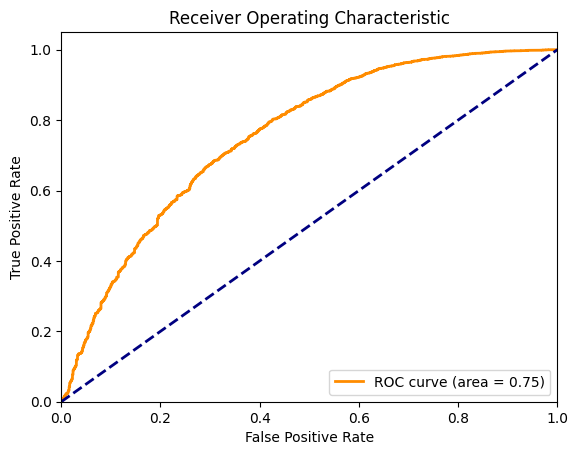

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# FPR, TPR, およびしきい値を計算する
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# AUC（Area Under Curve）を計算する
roc_auc = auc(fpr, tpr)

# ROC曲線をプロットする
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

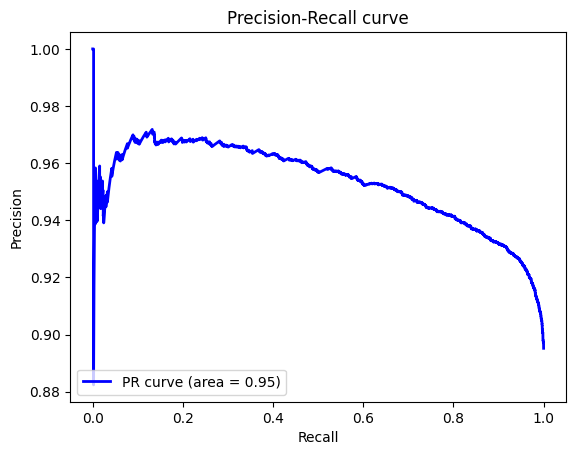

In [ ]:
from sklearn.metrics import precision_recall_curve, auc

# 精度と再現率を計算
precision, recall, thresholds = precision_recall_curve(y_val, y_pred)

# PR AUCを計算
pr_auc = auc(recall, precision)

# PR曲線をプロット
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')
plt.legend(loc="lower left")
plt.show()